In [139]:
"""
Inviscid Burgers Equation: Non-Conservative Form
    Spatial: WENO-5, CRWENO-5
    Temporal: RK3
"""
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import numpy.linalg
np.set_printoptions(threshold=sys.maxsize, linewidth=np.inf)


In [140]:
def InitialCondition(x):
    return np.sin(2*np.pi*x)

In [141]:
def BoundaryConditionDir(u):
    u[2],u[-3] = 0,0
    u[0] = 3*u[2] - 2*u[3] #
    u[1] = 2*u[2] - 1*u[3] #
    u[-2] = 2*u[-3]-1*u[-4]
    u[-1] = 3*u[-3]-2*u[-4]

def BoundaryConditionPer(u):
    u[2],u[-3] = 0,0
    u[[0,1]] = u[[-5,-4]]
    u[[-2,-1]] = u[[3,4]]

In [142]:
def WENOSmoothCoeffL(v1,v2,v3,v4,v5):
    eps = 1e-6
    dL = np.array([0.2, 0.5, 0.3])[:,np.newaxis]
    b = np.array([
        (13.0/12.0)*(v1-2.0*v2+v3)**2 + 0.25*(v1-4.0*v2+3.0*v3)**2,
        (13.0/12.0)*(v2-2.0*v3+v4)**2 + 0.25*(v2-v4)**2,
        (13.0/12.0)*(v3-2.0*v4+v5)**2 + 0.25*(3.0*v3-4.0*v4+v5)**2
    ])
    a = dL/(b+eps)**2
    return a/np.sum(a, axis=0)

def WENOSmoothCoeffR(v1,v2,v3,v4,v5):
    eps = 1e-6
    dR = np.array([0.3, 0.5, 0.2])[:,np.newaxis]
    b = np.array([
        (13.0/12.0)*(v1-2.0*v2+v3)**2 + 0.25*(v1-4.0*v2+3.0*v3)**2,
        (13.0/12.0)*(v2-2.0*v3+v4)**2 + 0.25*(v2-v4)**2,
        (13.0/12.0)*(v3-2.0*v4+v5)**2 + 0.25*(3.0*v3-4.0*v4+v5)**2
    ])
    a = dR/(b+eps)**2
    return a/np.sum(a, axis=0)

In [143]:
def WENOfromLeft(v1,v2,v3,v4,v5):
    # if the flow come from left
    # the velocity value at i+1/2
    # i-2, i-1, i | i+1, i+2
    wL = WENOSmoothCoeffL(v1,v2,v3,v4,v5)
    uL = (
        wL[0,:]*(v1/3.0 - 7.0/6.0*v2 + 11.0/6.0*v3) +
        wL[1,:]*(-v2/6.0 + 5.0/6.0*v3 + v4/3.0) +
        wL[2,:]*(v3/3.0 + 5.0/6.0*v4 - v5/6.0)
    )
    return uL

def WENOfromRight(v1,v2,v3,v4,v5):
    # if the flow come from left
    # the velocity value at i-1/2
    # i-2, i-1 | i , i+1, i+2
    wR = WENOSmoothCoeffR(v1,v2,v3,v4,v5)
    uR = (
        wR[0,:]*(-1.0/6.0*v1 + 5.0/6.0*v2 + 1.0/3.0*v3) +
        wR[1,:]*(v2/3.0 + 5.0/6.0*v3 - v4/6.0) +
        wR[2,:]*(11.0*v3/6.0 - 7.0/6.0*v4 +1.0/3.0*v5)
    )
    return uR

The correct equation should be
$$\begin{aligned} 
    \frac{1}{3} w_1^R u_{i-\frac{3}{2}}^R+ & {\left[\frac{1}{3} w_3^R+\frac{2}{3}\left(w_2^R+w_1^R\right)\right] u_{i-\frac{1}{2}}^R+\left(\frac{2}{3} w_3^R+\frac{1}{3} w_2^R\right) u_{i-\frac{1}{2}}^R=} \\ 
    & \frac{w_2^R + 5.0w_1^R}{6} u_{i-1}+\frac{5\left(w_3^R+w_2^R\right)+w_1^R}{6} u_i+\frac{w_3^R}{6} u_{i+1},
\end{aligned}$$

In [144]:
def CRWENOLeftMatabcrhs(v1,v2,v3,v4,v5):
    wL = WENOSmoothCoeffL(v1,v2,v3,v4,v5)
    rhs = wL[0,:]*v2 + (5*wL[0,:]+5*wL[1,:]+wL[2,:])*v3 + (wL[1,:]+5*wL[2,:])*v4
    rhs /= 6
    a = 2/3*wL[0,:]+1/3*wL[1,:]
    b = 1/3*wL[0,:]+2/3*wL[1,:]+2/3*wL[2,:]
    c = 1/3*wL[2,:]
    return a,b,c,rhs

def SolveCRWENOLeft_Dir(v1,v2,v3,v4,v5):
    a,b,c,rhs = CRWENOLeftMatabcrhs(v1,v2,v3,v4,v5)
    A = scipy.sparse.diags([[*a,0], [1,*b,1], [0,*c]], [-1,0,1]).toarray()
    rhsMod = np.array([1.5*v3[0] - 0.5*v3[1], *rhs, 2.5*v5[-3]-1.5*v5[-4]]) # interpolation to specigy BC
    uFace = np.linalg.solve(A, rhsMod)
    return uFace

def SolveCRWENOLeft_Per(v1,v2,v3,v4,v5):
    a,b,c,rhs = CRWENOLeftMatabcrhs(v1,v2,v3,v4,v5)
    A = scipy.sparse.diags([[*a,0], [1,*b,1], [0,*c]], [-1,0,1]).toarray()
    A[0,-3] = A[-1,2] = -1
    rhsMod = np.array([0, *rhs, 0]) # interpolation to specigy BC
    uFace = np.linalg.solve(A, rhsMod)
    return uFace

def CRWENORightMatabcrhs(v1,v2,v3,v4,v5):
    wR = WENOSmoothCoeffR(v1,v2,v3,v4,v5)
    rhs = (wR[1,:]+5*wR[0,:])*v2 + (wR[0,:]+5*wR[1,:]+5*wR[2,:])*v3 + wR[2,:]*v4 # equation is wrong in Journal
    rhs /= 6
    a = 1/3*wR[0,:] # equation is wrong in Journal
    b = 2/3*wR[0,:]+2/3*wR[1,:]+1/3*wR[2,:]
    c = 1/3*wR[1,:]+2/3*wR[2,:] # equation is wrong in Journal
    return a,b,c,rhs

def SolveCRWENORight_Per(v1,v2,v3,v4,v5):
    a,b,c,rhs = CRWENORightMatabcrhs(v1,v2,v3,v4,v5)
    A = scipy.sparse.diags([[*a,0], [1,*b,1], [0,*c]], [-1,0,1]).toarray()
    A[0,-3] = A[-1,2] = -1
    rhsMod = np.array([2.5*v3[0] - 1.5*v3[1], *rhs, 1.5*v5[-3]-0.5*v5[-4]])
    uFace = np.linalg.solve(A, rhsMod)
    return uFace

In [145]:
def RK3WENO(uOrig, dX, dT, BCfun):
    # NOTE: the journal is incorrect please have a look on
    # Proposition 3.2 in TOTAL VARIATION DIMINISHING RUNGE-KUTTA SCHEMES
    uOne = uOrig*np.nan
    uTwo = uOrig*np.nan
    uNow = uOrig*np.nan
    # First Intermediate
    uOne[3:-3] = uOrig[3:-3] - dT/dX * (
        np.maximum(uOrig[3:-3],0) * (
            WENOfromLeft(uOrig[1:-5], uOrig[2:-4], uOrig[3:-3], uOrig[4:-2], uOrig[5:-1]) -
            WENOfromLeft(uOrig[0:-6], uOrig[1:-5], uOrig[2:-4], uOrig[3:-3], uOrig[4:-2])
        ) +
        np.minimum(uOrig[3:-3],0) * (
            WENOfromRight(uOrig[2:-4], uOrig[3:-3], uOrig[4:-2], uOrig[5:-1], uOrig[6:]) -
            WENOfromRight(uOrig[1:-5], uOrig[2:-4], uOrig[3:-3], uOrig[4:-2], uOrig[5:-1])
        )
    )
    BCfun(uOne)

    # Second Intermediate
    uTwo[3:-3] = 3./4. * uOrig[3:-3] + 1./4. * uOne[3:-3] - 0.25 * dT/dX * (
        np.maximum(uOne[3:-3],0) * (
            WENOfromLeft(uOne[1:-5], uOne[2:-4], uOne[3:-3], uOne[4:-2], uOne[5:-1]) -
            WENOfromLeft(uOne[0:-6], uOne[1:-5], uOne[2:-4], uOne[3:-3], uOne[4:-2])
        ) +
        np.minimum(uOne[3:-3],0) * (
            WENOfromRight(uOne[2:-4], uOne[3:-3], uOne[4:-2], uOne[5:-1], uOne[6:]) -
            WENOfromRight(uOne[1:-5], uOne[2:-4], uOne[3:-3], uOne[4:-2], uOne[5:-1])
        )
    )
    BCfun(uTwo)

    # Final
    uNow[3:-3] = 1./3. * uOrig[3:-3] + 2./3. * uTwo[3:-3] - 2.0/3.0 * dT/dX * (
        np.maximum(uTwo[3:-3],0) * (
            WENOfromLeft(uTwo[1:-5], uTwo[2:-4], uTwo[3:-3], uTwo[4:-2], uTwo[5:-1]) -
            WENOfromLeft(uTwo[0:-6], uTwo[1:-5], uTwo[2:-4], uTwo[3:-3], uTwo[4:-2])
        ) +
        np.minimum(uTwo[3:-3],0) * (
            WENOfromRight(uTwo[2:-4], uTwo[3:-3], uTwo[4:-2], uTwo[5:-1], uTwo[6:]) -
            WENOfromRight(uTwo[1:-5], uTwo[2:-4], uTwo[3:-3], uTwo[4:-2], uTwo[5:-1])
        )
    )
    BCfun(uNow)
    return uNow

In [146]:
def RK3CRWENO(uOrig, dX, dT, BCfun):
    uOne = uOrig*np.nan
    uTwo = uOrig*np.nan
    uNow = uOrig*np.nan
    SolveCRWENOLeft = SolveCRWENOLeft_Per
    SolveCRWENORight = SolveCRWENOLeft_Per
    # First Intermediate
    uLeft = SolveCRWENOLeft(uOrig[0:-4], uOrig[1:-3], uOrig[2:-2], uOrig[3:-1], uOrig[4:])
    uRight = SolveCRWENORight(uOrig[0:-4], uOrig[1:-3], uOrig[2:-2], uOrig[3:-1], uOrig[4:])
    uOne[3:-3] = uOrig[3:-3] - dT/dX * (
        np.maximum(uOrig[3:-3],0) * (
            uLeft[2:-2] -
            uLeft[1:-3]
        ) +
        np.minimum(uOrig[3:-3],0) * (
            uRight[3:-1] -  # equation is wrong again here
            uRight[2:-2]
        )
    )
    BCfun(uOne)

    # Second Intermediate
    uLeft = SolveCRWENOLeft(uOne[0:-4], uOne[1:-3], uOne[2:-2], uOne[3:-1], uOne[4:])
    uRight = SolveCRWENORight(uOne[0:-4], uOne[1:-3], uOne[2:-2], uOne[3:-1], uOne[4:])
    uTwo[3:-3] = 3./4. * uOrig[3:-3] + 1./4. * uOne[3:-3] - 0.25 * dT/dX * (
        np.maximum(uOne[3:-3],0) * (
            uLeft[2:-2] -
            uLeft[1:-3]
        ) +
        np.minimum(uOne[3:-3],0) * (
            uRight[3:-1] -
            uRight[2:-2]
        )
    )
    BCfun(uTwo)

    # Final
    uLeft = SolveCRWENOLeft(uTwo[0:-4], uTwo[1:-3], uTwo[2:-2], uTwo[3:-1], uTwo[4:])
    uRight = SolveCRWENORight(uTwo[0:-4], uTwo[1:-3], uTwo[2:-2], uTwo[3:-1], uTwo[4:])
    uNow[3:-3] = 1./3. * uOrig[3:-3] + 2./3. * uTwo[3:-3] - 2.0/3.0 * dT/dX * (
        np.maximum(uTwo[3:-3],0) * (
            uLeft[2:-2] -
            uLeft[1:-3]
        ) +
        np.minimum(uTwo[3:-3],0) * (
            uRight[3:-1] -
            uRight[2:-2]
        )
    )
    BCfun(uNow)
    return uNow

In [147]:
# Domain   0...1
xMin, xMax = (0., 1.)
numPoint = 201
xPoints = np.linspace(xMin, xMax, num=numPoint)
deltaX = xPoints[1] - xPoints[0]
xPwG = np.array([
    *(xPoints[0:2]-2*deltaX), *xPoints,*(xPoints[-2:]+2*deltaX)
])

# temporal
tStart = 0.0
tEnd = 0.25
deltaT = 1e-4

# how many state to save (w/o initial condition)
numSaveState = 10
timeState = np.linspace(tStart,tEnd,numSaveState+1,endpoint=True)
States = np.zeros((numSaveState+1, xPwG.shape[0]))*np.nan


In [148]:
uInitial = InitialCondition(xPwG)
BoundaryConditionPer(uInitial)

uOriginal = uInitial*1.0
States[0, :] = uOriginal

tNow = tStart

In [149]:

while (tNow < tEnd-deltaT*0.01):
    tNow += deltaT
    uOriginal = RK3CRWENO(uOriginal, deltaX, deltaT, BoundaryConditionPer)
    
    if np.min(np.abs(tNow-timeState)) < deltaT*0.2:
        States[np.argmin(np.abs(tNow-timeState)), :] = uOriginal

Text(0.5, 1.0, 'Time Evolution of Values')

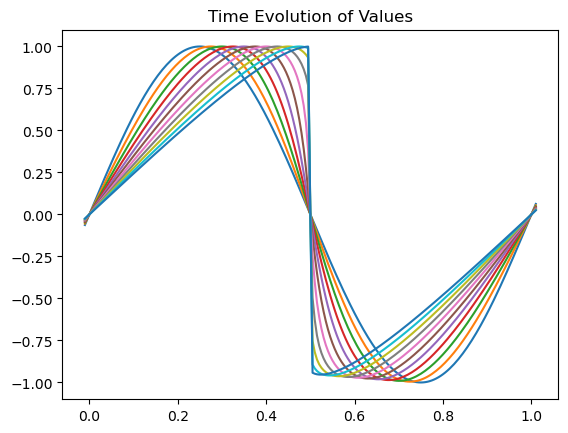

In [150]:
fig, ax = plt.subplots()
for i in range(numSaveState+1):
    ax.plot(xPwG, States[i,:], linestyle="-")  
ax.set_ylim([-1.1,1.1])
ax.set_title("Time Evolution of Values")

Text(0.5, 1.0, 'Right Face Velocity Test')

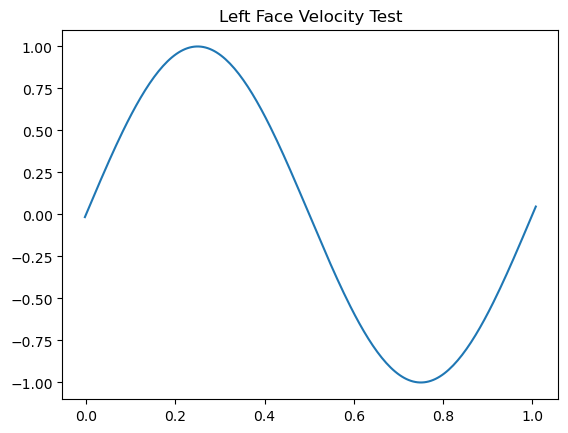

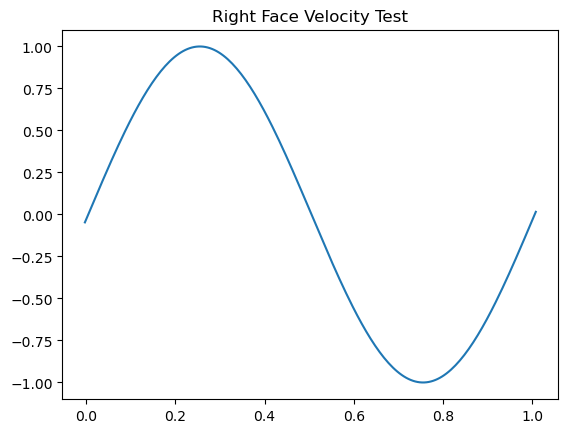

In [151]:
uOrig = InitialCondition(xPwG)
uLeft = SolveCRWENOLeft(uOrig[0:-4], uOrig[1:-3], uOrig[2:-2], uOrig[3:-1], uOrig[4:])
uRight = SolveCRWENORight(uOrig[0:-4], uOrig[1:-3], uOrig[2:-2], uOrig[3:-1], uOrig[4:])
xFace = np.delete((xPwG[1:]+xPwG[:-1])/2,0)

fig, ax = plt.subplots()
ax.plot(xFace, uLeft)
ax.set_ylim([-1.1,1.1])
ax.set_title("Left Face Velocity Test")

fig, ax = plt.subplots()
ax.plot(xFace, uRight)
ax.set_ylim([-1.1,1.1])
ax.set_title("Right Face Velocity Test")